In [273]:
import numpy as np
import pandas as pd

from urllib.request import urlopen
from xmltodict import parse
from zipfile import ZipFile
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from scipy import stats

import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram

# Univariate Linear Regression

Consider the following dataset:

In [294]:
def WBQuery(series,name):
    base = 'https://api.worldbank.org/v2/en/indicator/'
    with urlopen(f'{base}/{series}?downloadformat=xml') as url:
        zf = ZipFile(BytesIO(url.read()))
    f = zf.filelist[0]
    raw = parse(zf.open(f).read().decode('utf8'))
    res = []
    for item in raw['Root']['data']['record']:
        x = item['field']
        try:
            res.append({'country': x[0]['#text'],
                        'year': x[2]['#text'],
                        name: float(x[3]['#text'])})
        except:
            None
    return pd.DataFrame(res)

In [295]:
worldUrbanPop = WBQuery('SP.URB.TOTL.IN.ZS','urban_pop')
globalUrbanPop = worldUrbanPop.groupby('year').mean()
globalUrbanPop

,urban_pop
year,
1960,36.243845
1961,36.763893
1962,37.294984
1963,37.833980
1964,38.383669
...,...
2016,59.268115
2017,59.586065
2018,59.907127


<AxesSubplot:xlabel='year'>

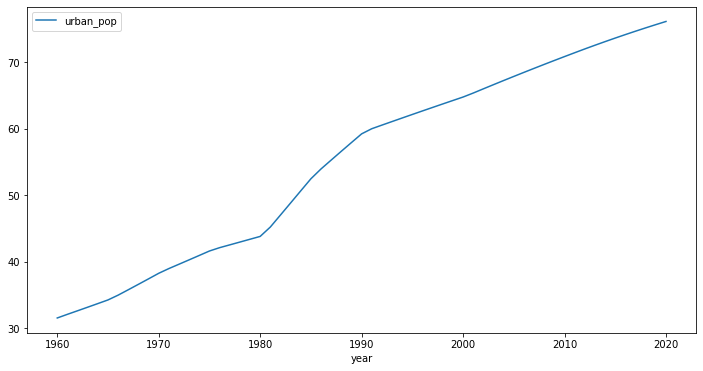

In [300]:
turUrbPop = worldUrbanPop[worldUrbanPop['country']=='Turkey'].groupby('year').mean()
turUrbPop.plot()

<AxesSubplot:xlabel='year'>

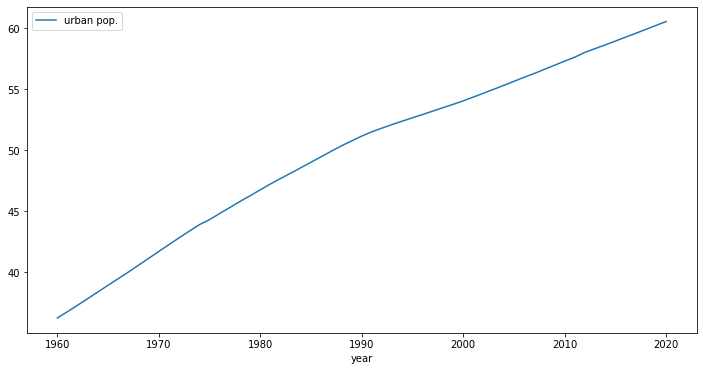

In [5]:
plt.rcParams['figure.figsize'] = 12,6
globalUrbanPop.plot()

It seems like one can fit a line to this data:

<AxesSubplot:ylabel='urban_pop'>

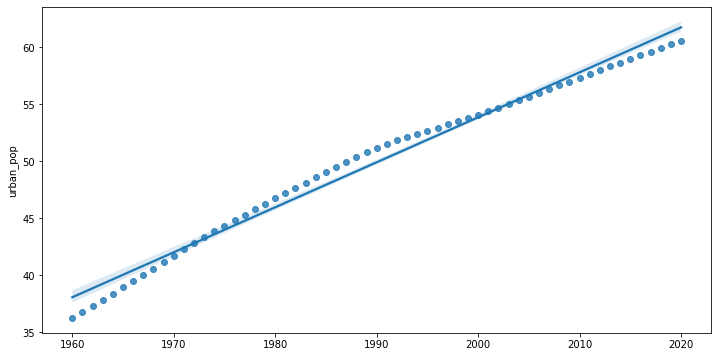

In [153]:
xs = np.array(globalUrbanPop.index.astype('float')).reshape((61,1))
ys = globalUrbanPop['urban_pop']

sns.regplot(x=xs,y=ys)

Here is how we construct the model and make predictions:

In [52]:
model = LinearRegression().fit(xs,ys)
model.predict(xs)

array([38.06071356, 38.45510278, 38.84949199, 39.24388121, 39.63827042,
       40.03265964, 40.42704886, 40.82143807, 41.21582729, 41.6102165 ,
       42.00460572, 42.39899493, 42.79338415, 43.18777337, 43.58216258,
       43.9765518 , 44.37094101, 44.76533023, 45.15971945, 45.55410866,
       45.94849788, 46.34288709, 46.73727631, 47.13166552, 47.52605474,
       47.92044396, 48.31483317, 48.70922239, 49.1036116 , 49.49800082,
       49.89239004, 50.28677925, 50.68116847, 51.07555768, 51.4699469 ,
       51.86433611, 52.25872533, 52.65311455, 53.04750376, 53.44189298,
       53.83628219, 54.23067141, 54.62506063, 55.01944984, 55.41383906,
       55.80822827, 56.20261749, 56.5970067 , 56.99139592, 57.38578514,
       57.78017435, 58.17456357, 58.56895278, 58.963342  , 59.35773121,
       59.75212043, 60.14650965, 60.54089886, 60.93528808, 61.32967729,
       61.72406651])

Since this is an ordinary model over a univariate data, we have only two parameters: the slope and the intercept. These are:

In [8]:
(model.coef_[0],model.intercept_)

(0.3943892158160649, -734.9421494386969)

The model score is a percentage. This score tells us how much of the variation in the data is explained by the model:
$$ R^2 = 1 - \frac{\sum_i (y_i-\alpha x_i - \beta_i)^2}{\sum_i (y_i - \bar{y})^2 } $$
Larger the $R^2$-score, better the model.

In [9]:
model.score(xs,ys)

0.9848937625998927

But there is an important question we haven't answered yet: how sure are about the model parameters (slope and the intercept)? 

$$ y = \beta_1 x + \beta_0 + \varepsilon \qquad \varepsilon \sim N(0,\sigma) $$

A good statistical model should give us **confidence intervals** about any measurement we make. So, how can we calculate these confidence intervals?

First of all, let us define 
$$ S_{xx} = \sum_i (x_i - \overline{x})^2
   \qquad
   S_{xy} = \sum_i (x_i - \overline{x})(y_i - \overline{y})
   \qquad
   \hat{\sigma}^2 = \frac{1}{n-2} \sum_i (y_i - \beta_1 x_i - \beta_0)^2
$$
Then
$$ \beta_1 = \frac{S_{xy}}{S_{xx}}, \quad \beta_0 = \overline{y} - \beta_1 \overline{x} $$
As for the standard errors:
$$ se(\beta_1) = \sqrt{\frac{\hat{\sigma}^2}{S_{xx}}}
   \qquad
   se(\beta_0) = \sqrt{\hat{\sigma}^2\left(\frac{1}{n} + \frac{\overline{x}^2}{S_{xx}}\right)}
$$
Then we use [the t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to test whether these coefficients are zero:
$$ t_{\beta_1} = \frac{\beta_1}{se(\beta_1)} > t_{p/2, n-2} 
   \qquad
   t_{\beta_0} = \frac{\beta_0}{se(\beta_0)} > t_{p/2, n-2}
$$

In [302]:
def regression(xs,ys):
    N = xs.shape[0]
    xbar = xs.mean()
    ybar = ys.mean()

    xcent = xs - xbar
    ycent = ys - ybar

    Sxx = np.dot(xcent, xcent)
    Sxy = np.dot(xcent, ycent)
    Syy = np.dot(ycent, ycent)

    beta1 = Sxy/Sxx 
    beta0 = ybar - beta1*xbar
    resid = ys - beta1*xcent - beta0

    Sigma2 = (1/(N-2))*np.linalg.norm(resid)
    R2 = 1.0 - Sigma2/Syy

    return {
     'beta_1': beta1,
     'beta_0': beta0,
     'se(beta_1)': np.sqrt(Sigma2/Sxx),
     'se(beta_0)': np.sqrt(Sigma2*(1/N + xbar*xbar/Sxx)),
     'R2': R2
    }

Here is the result for our data:

In [303]:
res = regression(xs.reshape(61),ys)
res

{'beta_1': 0.3943892158160648,
 'beta_0': -734.9421494386967,
 'se(beta_1)': 0.07412246823030857,
 'se(beta_0)': 147.5094850234109,
 'R2': 0.96521123031143}

Now we test if the coefficients are non-zero. The null hypothesis is that coefficients are zero. We use Student's t-test. I'll fix test the result at 95%:

In [308]:
alpha = 1e-5

(res['beta_1']/res['se(beta_1)'] > stats.t.isf(alpha/2.0, N-2),
 np.abs(res['beta_0']/res['se(beta_0)']) > stats.t.isf(alpha/2.0, N-2))

(True, True)

So, we can be sure that the coefficents are non-zero at this confidence level.

# Multivariate Regression

In [309]:
worldGDP = WBQuery('ny.gdp.pcap.cd','GDP')
worldGDP

,country,year,GDP
0,Aruba,1986,6472.398709
1,Aruba,1987,7885.158927
2,Aruba,1988,9765.909207
3,Aruba,1989,11392.269150
4,Aruba,1990,12306.717679
...,...,...,...
12832,Zimbabwe,2016,1464.588957
12833,Zimbabwe,2017,1235.189032
12834,Zimbabwe,2018,1254.642265
12835,Zimbabwe,2019,1316.740657


In [310]:
globalGDP = worldGDP.groupby('year').mean()
globalGDP

,GDP
year,
1960,482.725314
1961,491.115624
1962,513.103203
1963,544.566319
1964,590.805091
...,...
2016,15524.456868
2017,16308.827347
2018,17288.675629


<AxesSubplot:xlabel='year'>

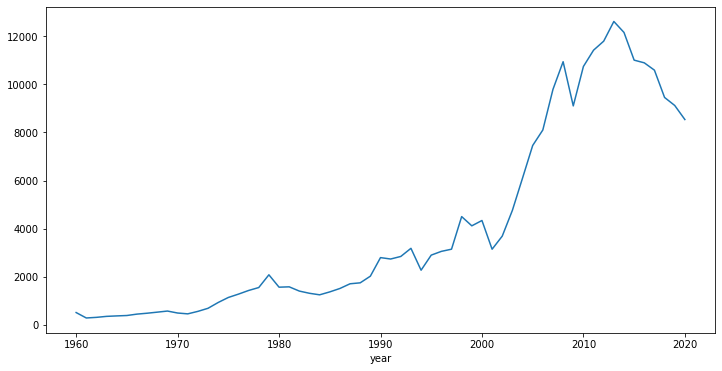

In [321]:
turkishGDP = worldGDP[worldGDP['country']=='Turkey']
turkishGDP.index = turkishGDP['year']
del turkishGDP['country']
turkishGDP['GDP'].plot()

In [329]:
turkishData = turUrbPop.join(turkishGDP,how='inner')
turkishData['year'] = turkishData['year'].astype(float)

<AxesSubplot:xlabel='year'>

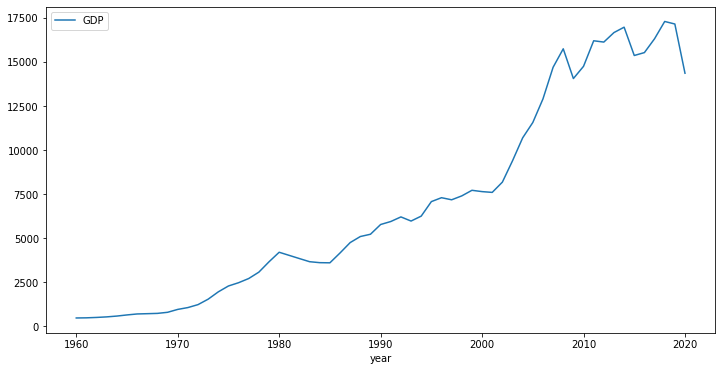

In [311]:
globalGDP.plot()

In [157]:
data = globalGDP.join(globalUrbanPop,how='inner')
data

,GDP,urban_pop
year,,
1960,482.725314,36.243845
1961,491.115624,36.763893
1962,513.103203,37.294984
1963,544.566319,37.833980
1964,590.805091,38.383669
...,...,...
2016,15524.456868,59.268115
2017,16308.827347,59.586065
2018,17288.675629,59.907127


In [158]:
data['year'] = range(1960,2021)
data

,GDP,urban_pop,year
year,,,
1960,482.725314,36.243845,1960
1961,491.115624,36.763893,1961
1962,513.103203,37.294984,1962
1963,544.566319,37.833980,1963
1964,590.805091,38.383669,1964
...,...,...,...
2016,15524.456868,59.268115,2016
2017,16308.827347,59.586065,2017
2018,17288.675629,59.907127,2018


So, here is a question: which is a better predictor for urban population? GDP or the year?

In [324]:
regression(turkishData['GDP'],turkishData['urban_pop'])

{'beta_1': 0.003116777959286902,
 'beta_0': 42.53550893041123,
 'se(beta_1)': 4.5221506587338355e-05,
 'se(beta_0)': 0.2559884669926498,
 'R2': 0.9998458715720978}

In [326]:
regression(turkishData['year'].astype(float),turkishData['urban_pop'])

{'beta_1': 0.8086359069275517,
 'beta_0': -1554.0004711792706,
 'se(beta_1)': 0.10613628976729285,
 'se(beta_0)': 211.21948337207584,
 'R2': 0.983098872283929}

But what if we put both variables into a regression? But for that we need multivariate regression:

# Multivariate Regression

Assume we have a sample $(x^{(i)},y^{(i)})_{i=1}^N$ where each $x^{(i)}$ is a $m$-dimensional vector. Let us write $X = (x^{(i)})$ and $y = (y^{(i)})$ where $X$ is an $N\times m$ matrix and $y$ is an $N\times 1$ column vector. We want to create a linear regression model of the form

$$ y \sim X \beta_1 + \beta_0 $$

where $\beta_1$ is a $m\times 1$ column vector.  One can further reduce the model to 

$$ y \sim X' \beta $$

by augmenting $X$ by a column of 1's. From now on, I'll write $X$ and for the augmented matrix $X'$.

If we multiply both sides with $X^t$ we get

$$ X^t y \sim X^t X \beta $$

When the columns of $X$ are linearly independent, $X^t X$ is an invertible matrix and we get

$$ \beta \sim (X^t X)^{-1} X^t y $$ 

So far so good. However, we still have to find standard errors for the coefficents. Let us start by calculating model variance

$$ \hat{\sigma}^2 = \frac{1}{N-m} \sum_{i=1}^n (y^{(i)} - \beta^t x^{(i)})^2 $$

Then $Var(\beta_j) = \hat{\sigma}^2 C_{jj}$ where $X^t X = (C_{ij})$

In [331]:
def multiRegression(xs,ys):
    N,m = xs.shape
    
    ybar = ys.mean()
    ycent = ys - ybar
    Syy = np.dot(ycent,ycent)
    
    X = np.c_[np.ones(xs.shape[0]),xs]
    Xt = X.transpose()
    XXt = np.linalg.inv(np.matmul(Xt,X))
    beta = np.matmul(np.matmul(XXt,Xt),ys)
    
    resid = ys - np.matmul(beta,X.transpose())
    sigma2 = (1.0/(N-m))*np.dot(resid,resid)
    se = np.sqrt(sigma2*np.diag(XXt))
    R2 = 1.0 - sigma2/Syy
    
    return ({'beta': beta, 'R2': R2, 'SE(beta)': se})

The intercept is the first term in the returned vector $\beta$, and therefore, the first terms in the standard error vector goes with the intercept. 

In [332]:
res = multiRegression(turkishData[['GDP','year']],turkishData['urban_pop'])
res

{'beta': array([-1.77104316e+03, -5.49684357e-04,  9.18823642e-01]),
 'R2': 0.9997561556696791,
 'SE(beta)': array([5.62533892e+01, 1.27155436e-04, 2.84995065e-02])}

In [162]:
regression(data['GDP'],data['urban_pop'])

{'beta_1': 0.001157356360078545,
 'beta_0': 41.81921720551001,
 'se(beta_1)': 2.4232007399765155e-05,
 'se(beta_0)': 0.21679087000447853,
 'R2': 0.9996236195543639}

In [163]:
regression(data['year'],data['urban_pop'])

{'beta_1': 0.3943892158160648,
 'beta_0': -734.9421494386967,
 'se(beta_1)': 0.07412246823030857,
 'se(beta_0)': 147.5094850234109,
 'R2': 0.96521123031143}

In [334]:
alpha = 5e-2

N = data.shape[0]
m = 3

np.abs(res['beta']/res['SE(beta)']) > stats.t.isf(alpha/2.0, N-m)*np.ones(3)

array([ True,  True,  True])

In [148]:
multiRegression(data['GDP'].to_numpy().reshape((61,1)),data['urban pop.'])

{'beta': array([4.18192172e+01, 1.15735636e-03]),
 'R2': 0.9976430561365393,
 'SE(beta)': array([5.42502922e-01, 6.06387844e-05])}

# There is a library for that

Well, the good news is that we didn't have to implement this by hand:


In [150]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [167]:
model = ols('urban_pop ~ year + GDP', data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              urban_pop   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3995.
Date:                Mon, 21 Mar 2022   Prob (F-statistic):           7.47e-63
Time:                        23:03:55   Log-Likelihood:                -54.779
No. Observations:                  61   AIC:                             115.6
Df Residuals:                      58   BIC:                             121.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -970.1991     30.792    -31.508      0.000   -1031.836    -908.562
year           0.5140      0.016     32.866      0.000       0.483       0.545
GDP           -0.0004   4.92e-05     -7.974      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        2.320   Durbin-Watson:                   0.218
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.206
Skew:                          -0.449   Prob(JB):                        0.332
Kurtosis:                       2.752   Cond. No.                     3.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OK. We have two independent variables. Which one is more important for the model? If we were to drop one variable, which one should we drop? For that we need to look at the ANOVA (ANalysis Of VAriance) table.

In [168]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
year,1.0,2941.315361,2941.315361,7926.972350,9.848430e-64
GDP,1.0,23.592717,23.592717,63.583394,6.773310e-11
Residual,58.0,21.520990,0.371052,NaN,NaN


# Colinearity Problems

In [335]:
mtcars = data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
                            header=None,
                            sep='\s+')

mtcars.columns = [  "mpg",  
                    "cylinders",  
                    "displacement",  
                    "horsepower",  
                    "weight",  
                    "acceleration",
                    "year",  
                    "origin",  
                    "name"]
mtcars

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [248]:
tmp = mtcars.iloc[:,:-2]
tmp['horsepower'] = tmp['horsepower'].replace('?',np.nan).astype(float)
tmp.dropna(inplace=True)

<AxesSubplot:>

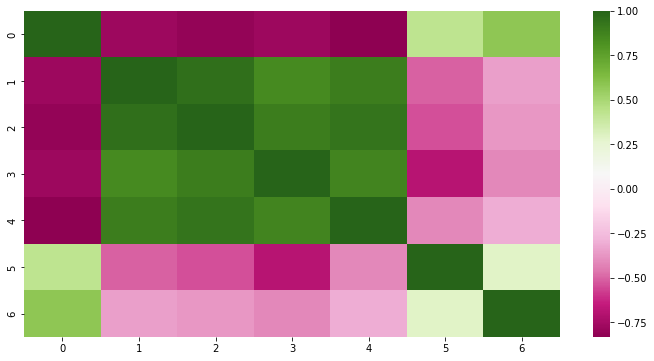

In [249]:
cor = np.corrcoef(tmp.transpose())
sns.heatmap(cor,cmap='PiYG')

In [ ]:
"mpg",  
                    "cylinders",  
                    "displacement",  
                    "horsepower",  
                    "weight",  
                    "acceleration",
                    "year",  
                    "origin",  
                    "name"

In [347]:
model = ols("mpg ~ weight + year + displacement + horsepower + acceleration + cylinders", data=tmp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     272.2
Date:                Tue, 22 Mar 2022   Prob (F-statistic):          3.79e-135
Time:                        14:55:40   Log-Likelihood:                -1036.5
No. Observations:                 392   AIC:                             2087.
Df Residuals:                     385   BIC:                             2115.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -14.5353      4.764     -3.051      0.002     -23.902      -5.169
weight          -0.0068      0.001    -10.141      0.000      -0.008      -0.005
year             0.7534      0.053     14.318      0.000       0.650       0.857
displacement     0.0077      0.007      1.044      0.297      -0.007       0.022
horsepower      -0.0004      0.014     -0.028      0.977      -0.028       0.027
acceleration     0.0853      0.102      0.836      0.404      -0.115       0.286
cylinders       -0.3299      0.332     -0.993      0.321      -0.983       0.323
==============================================================================
Omnibus:                       37.865   Durbin-Watson:                   1.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.248
Skew:                           0.630   Prob(JB):                     8.26e-14
Kurtosis:                       4.449   Cond. No.                     8.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [348]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
weight,1.0,16497.759763,16497.759763,1398.008445,3.277947e-130
year,1.0,2752.281665,2752.281665,233.226393,1.675205e-41
displacement,1.0,0.042045,0.042045,0.003563,9.524336e-01
horsepower,1.0,4.650772,4.650772,0.394103,5.305227e-01
acceleration,1.0,9.270309,9.270309,0.785559,3.759995e-01
cylinders,1.0,11.641891,11.641891,0.986526,3.212169e-01
Residual,385.0,4543.347025,11.800901,NaN,NaN


In [343]:
model = ols("mpg ~ year + weight + cylinders", data=tmp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     545.6
Date:                Tue, 22 Mar 2022   Prob (F-statistic):          8.73e-139
Time:                        14:53:15   Log-Likelihood:                -1037.3
No. Observations:                 392   AIC:                             2083.
Df Residuals:                     388   BIC:                             2099.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.9076      4.066     -3.420      0.001     -21.902      -5.913
year           0.7520      0.050     14.987      0.000       0.653       0.851
weight        -0.0064      0.000    -13.746      0.000      -0.007      -0.005
cylinders     -0.1517      0.234     -0.649      0.517      -0.611       0.308
==============================================================================
Omnibus:                       43.326   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.042
Skew:                           0.678   Prob(JB):                     8.35e-17
Kurtosis:                       4.642   Cond. No.                     7.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [344]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
year,1.0,8027.663284,8027.663284,682.457820,1.589354e-87
weight,1.0,11222.378144,11222.378144,954.050943,1.339861e-106
cylinders,1.0,4.958104,4.958104,0.421505,5.165714e-01
Residual,388.0,4563.993938,11.762871,NaN,NaN


In [278]:
tmp.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year'],
      dtype='object')